# 1 - Training Robust Neural Networks

Learn how to train neural networks in a robust way. In this chapter, you will use object-oriented programming to define PyTorch datasets and models and refresh your knowledge of training and evaluating neural networks. You will also get familiar with different optimizers and, finally, get to grips with various techniques that help mitigate the problems of unstable gradients so ubiquitous in neural nets training.

## Prepare environment

### Import libraries

In [1]:
import expectexception
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment

from typing import List, Tuple
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

### Global variables

In [2]:
# global variables
SEED = 42

DATASET_FILE_WATER_POTABILITY_TRAIN = 'data-sources/water_train.csv'
DATASET_FILE_WATER_POTABILITY_TEST = 'data-sources/water_test.csv'

### GPU Validation

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

True

### Global Configuration

In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

## 1.1 PyTorch and object-oriented programming

Types:
- Convolutional Neural Networks (CNNs) >> **for image data**
- Recurrent Neural Networks (RNNs) >> **for sequence data**

> Sequence data refers to a type of data where the order of elements is significant, and the 
> elements are typically arranged in a specific sequence or chronological order. In sequence
> data, each element in the sequence is related to the ones that come before and after it, and
> the way these elements are ordered provides context, meaning, and structure to the data.

### Water potability dataset

In [5]:
# Exploring the dataset
df = pd.read_csv(DATASET_FILE_WATER_POTABILITY_TRAIN)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.483566,0.615597,0.513964,0.777394,0.354601,0.335319,0.367332,0.514102,0.617313,1
1,0.639608,0.516021,0.380558,0.390190,0.628308,0.157487,0.451506,0.558650,0.834925,0
2,0.370117,0.847246,0.623556,0.992911,0.145461,0.345829,0.334781,0.402932,0.590146,1
3,0.545159,0.261747,0.292037,0.535522,0.436155,0.713600,0.667406,0.471880,0.138483,0
4,0.610883,0.525235,0.465619,0.475133,0.634338,0.196409,0.623423,0.520589,0.755856,0


### PyTorch Dataset

In [6]:
class CSVDataSet(Dataset):
    """
    PyTorch Dataset extended to load the data based on a given CSV file
    Assumptions:
    - Only CSV files can be imported.
    - All columns in the CSV file are included unless the `cols_to_include` list is defined. 
      In that case only the columns' name included in the list are considered.
    - The last column of the loaded dataset is the target/label column.
    """
    
    def __init__(self, csv_path:str, cols_to_include:List['str'] = None) -> None:
        super().__init__
        data = pd.read_csv(csv_path)
        if cols_to_include:
            data = data[cols_to_include]
        self.data = data.to_numpy()

    def __len__(self) -> int:
        return self.data.shape[0]

    def __getitem__(self, idx:int) -> Tuple[np.ndarray, np.ndarray]:
        features = self.data[idx, :-1]
        label = self.data[idx, -1]
        return features, label

In [7]:
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)
f, l = dataset_train[0]
print(f"""
Len: {len(dataset_train)}
First row:
- features >> {f}
- label >> {l}
""")


Len: 1508
First row:
- features >> [0.48356615 0.61559711 0.51396405 0.7773939  0.35460138 0.33531893
 0.36733186 0.51410184 0.6173129 ]
- label >> 1.0



### PyTorch DataLoader

In [8]:
# Reproducibility
torch.manual_seed(SEED)

# Dataloader creation
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
)

# Getting the first element
features, labels = next(iter(dataloader_train))
print(f"Features: {features},\nLabels: {labels}")

Features: tensor([[0.3591829085, 0.6595818988, 0.2034204507, 0.4746364356, 0.5283256004,
         0.3724379962, 0.4664738513, 0.2391769927, 0.4438566100],
        [0.7397018886, 0.3852037335, 0.6091506878, 0.4229626350, 0.6116208737,
         0.5254394621, 0.6915807637, 0.3164621322, 0.5469324139]],
       dtype=torch.float64),
Labels: tensor([0., 1.], dtype=torch.float64)


### PyTorch Model - WaterModel

In [9]:
# Sequential model definition
model = nn.Sequential(
    nn.Linear(9, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)
model

Sequential(
  (0): Linear(in_features=9, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)

**We have to apply the `nn.functional.relu` function directly on the input data without any learnable parameters. 
On the other hand, the `nn.ReLU` function includes the learnable parameters like weights and biases.**

In [10]:
# Class-based model definition
class WaterModel(nn.Module):
    """Basic model for binary classifier problems."""
    def __init__(self, seed=SEED):
        # super(NnModel, self).__init__()   # in old python version
        super().__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = x.float()
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x.double()

watermodel = WaterModel()
watermodel

WaterModel(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

### Ex.1 - PyTorch Dataset

Time to refresh your PyTorch Datasets knowledge!

Before model training can commence, you need to load the data and pass it to the model in the right format. In PyTorch, this is handled by Datasets and DataLoaders. Let's start with building a PyTorch Dataset for our water potability data.

In this exercise, you will define a class called `CSVDataSet` to load the data from a CSV file. To do this, you will need to implement the three methods which PyTorch expects a Dataset to have:

- .__init__() to load the data,
- .__len__() to return data size,
- .__getitem()__ to extract features and label for a single sample.

**Instructions**

1. In the `.__init__()` method, load the data from `csv_path` to a pandas DataFrame.
2. Convert the extracted data to a `NumPy` array and assign the result to `self.data`.
3. Implement the .__len__() method to return the number of data samples.

-------------------------------
```
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()

    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx, -1]
        return features, label
```

### Ex.2 - PyTorch DataLoader
Good job defining the Dataset class! The `CSVDataSet` you just created is now available for you to use.

The next step in preparing the training data is to set up a `DataLoader`. A PyTorch `DataLoader` can be created from a Dataset to load data, split it into batches, and perform transformations on the data if desired. Then, it yields a data sample ready for training.

In this exercise, you will build a `DataLoader` based on the `CSVDataSet`. The `DataLoader` class you will need has already been imported for you from `torch.utils.data`. Let's get to it!

**Instructions**

1. Create an instance of `CSVDataSet` from `water_train.csv`, assigning it to `dataset_train`.
2. Create `dataloader_train` based on `dataset_train`, using a batch size of two and shuffling the samples.
3. Get a batch of features and labels from the `DataLoader` and print them.

In [11]:
# Create an instance of the WaterDataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(f"""
Features: 
{features}

Labels: {labels}
""")


Features: 
tensor([[0.5657166106, 0.5097209306, 0.4056346563, 0.7058536487, 0.5509024638,
         0.3518412955, 0.4489813240, 0.5221939984, 0.3446112952],
        [0.5941521894, 0.6618290366, 0.4848585255, 0.3656099262, 0.6632648759,
         0.5753103565, 0.4951166302, 0.4076439824, 0.3027623536]],
       dtype=torch.float64)

Labels: tensor([1., 0.], dtype=torch.float64)



### Ex.3 - PyTorch Model

You will use the OOP approach to define the model architecture. Recall that this requires setting up a model class and defining two methods inside it:

- `.__init__()`, in which you define the layers you want to use;
- `forward()`, in which you define what happens to the model inputs once it receives them; this is where you pass inputs through pre-defined layers.

Let's build a model with three linear layers and ReLU activations. After the last linear layer, you need a sigmoid activation instead, which is well-suited for binary classification tasks like our water potability prediction problem. Here's the model defined using `nn.Sequential()`, which you may be more familiar with:

```
net = nn.Sequential(
    nn.Linear(9, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)
```

Let's rewrite this model as a class!

**Instructions**

1. In the `.__init__()` method, define the three linear layers with dimensions corresponding to the model definition provided and assign them to `self.fc1`, `self.fc2`, and `self.fc3`, respectively.
2. In the `forward()` method, pass the model input `x` through all the layers, remembering to add activations on top of them, similarly how it's already done for the first layer.

-----------------------------
```
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x
```

## 1.2 Training loop

### Build the model

In [12]:
# Getting the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)

# Building the model
watermodel = WaterModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(watermodel.parameters(), lr=0.01, momentum=0.95)
watermodel

WaterModel(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

### Train the model with `optim.SGD`

In [13]:
# Loop through the dataset multiple times
losses = []
epochs = int(1e3)
watermodel.train()
for epoch in range(epochs):
    for X, y in dataloader_train:
        optimizer.zero_grad()
        y_pred = watermodel(X)
        loss = criterion(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.6354
Epoch [200], Loss: 0.6573
Epoch [300], Loss: 0.6985
Epoch [400], Loss: 0.6715
Epoch [500], Loss: 0.6928
Epoch [600], Loss: 0.6218
Epoch [700], Loss: 0.6625
Epoch [800], Loss: 0.6383
Epoch [900], Loss: 0.5942
Epoch [1000], Loss: 0.6460


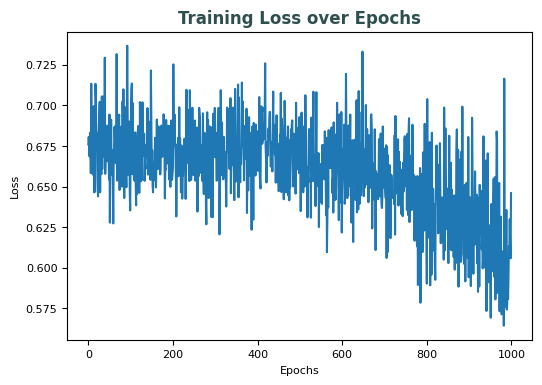

In [14]:
# Visualizing the loss data in training set
fig = plt.figure(figsize=(6,4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Other optimizers

#### Stochastic Gradient Descent (SGD)

- Update depends on learning rate
- Simple and efficient, for basic models
- Rarely used in practice

In [15]:
optim.SGD(watermodel.parameters(), lr=0.01)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

#### Adaptive Gradient (Adagrad)

- Adapts learning rate for each parameter
- Good for sparse data
- May decrease the learning rate too fast

In [16]:
optim.Adagrad(watermodel.parameters(), lr=0.01)

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

#### Root Mean Square Propagation (RMSprop)

- Update for each parameter based on the size of its previous gradients

In [17]:
optim.RMSprop(watermodel.parameters(), lr=0.01)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

#### Adaptive Moment Estimation (Adam)

- Arguably the most versatile and widely used
- RMSprop + gradient momentum
- Often used as the go-to optimizer

In [18]:
optim.Adam(watermodel.parameters(), lr=0.01)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### Model evaluation

In [19]:
# Getting the dataset
dataset_test = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TEST)

# Create a DataLoader based on dataset_train
dataloader_test = DataLoader(dataset_test, batch_size=200, shuffle=True)

# Setting the accuracy metrics
acc = Accuracy(task="binary")

# Evaluating the model
watermodel.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = watermodel(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

accuracy = acc.compute()
print(f"Accuracy: {accuracy}")

Accuracy: 0.6381709575653076


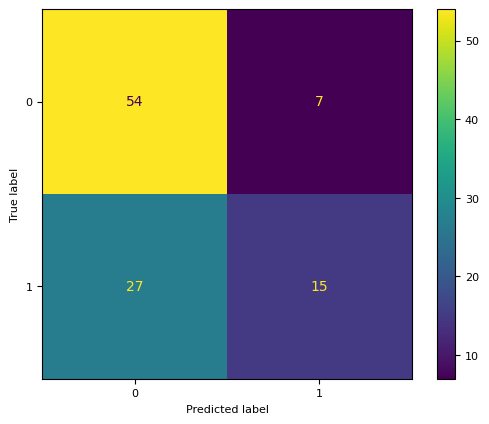

In [20]:
cm = confusion_matrix(labels.numpy(), 
                      preds.numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

### Ex.4 - Optimizers
It's time to explore the different optimizers that you can use for training your model.

A custom function called `train_binary_classifier_model(optimizer, model, epochs, dataloader)` has been defined for you. It takes the optimizer, the model, and the number of epochs as inputs, runs the training loops, and prints the training loss at the end.

Let's use `train_binary_classifier_model()` to run a few short trainings with different optimizers and compare the results!

**Instructions**

1. Define the optimizer as Stochastic Gradient Descent.
2. Define the optimizer as Root Mean Square Propagation (RMSprop), passing the model's parameters as its first argument.
3. Define the optimizer as Adaptive Moments Estimation (Adam), setting the learning rate to 0.001.

In [21]:
# Util functions
def train_binary_classifier_model(optimizer, model, epochs, dataloader):
    """Functions to train a binary classifier model"""
    
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        running_loss = 0.
        for features, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_loss = running_loss / len(dataloader_train)
    print(f"Training loss after {epochs} epochs: {train_loss}")

In [22]:
# Getting the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)

#### Stochastic Gradient Descent (SGD)

In [23]:
model = WaterModel()

# Define the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

train_binary_classifier_model(optimizer=optimizer, model=model, epochs=10, dataloader=dataloader_train)

Training loss after 10 epochs: 0.6733608950131746


#### Root Mean Square Propagation (RMSprop)

In [24]:
model = WaterModel()

# Define the RMSprop optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

train_binary_classifier_model(optimizer=optimizer, model=model, epochs=10, dataloader=dataloader_train)

Training loss after 10 epochs: 0.6729148143615372


#### Adaptive Moments Estimation (Adam)

In [25]:
model = WaterModel()

# Define the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_binary_classifier_model(optimizer=optimizer, model=model, epochs=10, dataloader=dataloader_train)

Training loss after 10 epochs: 0.673271356709781


> Great job! Model training has some randomness to it and each time you get slightly different results, but it's very likely that you saw RMSprop and Adam decreasing the loss more than a simple SGD even after just 10 training epochs.

### Ex.5 - Model evaluation

With the training loop sorted out, you have trained the model for `1e3` epochs, and it is available to you as model. You have also set up a test_dataloader in exactly the same way as you did with `train_dataloader` before—just reading the data from the test rather than the train directory.

You can now evaluate the model on test data. To do this, you will need to write the evaluation loop to iterate over the batches of test data, get the model's predictions for each batch, and calculate the accuracy score for it. Let's do it!

**Instructions**

1. Set up the evaluation metric as `Accuracy` for binary classification and assign it to acc.
2. For each batch of test data, get the model's outputs and assign them to outputs.
3. After the loop, compute the total test accuracy and assign it to `test_accuracy`.

#### Build the model - WaterModel2

In [26]:
# Class-based model definition
class WaterModel2(nn.Module):
    """Basic model for binary classifier problems using Sequential."""
    def __init__(self, seed=SEED):
        super().__init__()
        
        torch.manual_seed(seed)
        self.model = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.float()
        x = self.model(x)
        return x.double()

model = WaterModel2()
model

WaterModel2(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [27]:
# Getting the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)

# Set the criterion and teh optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train the model

In [28]:
# Loop through the dataset multiple times
losses = []
epochs = int(1e3)
model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.6248
Epoch [200], Loss: 0.6338
Epoch [300], Loss: 0.6618
Epoch [400], Loss: 0.6621
Epoch [500], Loss: 0.6602
Epoch [600], Loss: 0.5986
Epoch [700], Loss: 0.6498
Epoch [800], Loss: 0.6445
Epoch [900], Loss: 0.6001
Epoch [1000], Loss: 0.6665


#### Evaluate the model

In [29]:
# Get the dataset
dataset_test = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TEST)

# Create a DataLoader based on dataset_train
dataloader_test = DataLoader(dataset_test, batch_size=200, shuffle=True)

# Set up binary accuracy metric
acc = Accuracy(task="binary")

# Evaluate the model
model.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

# Compute total test accuracy
accuracy = acc.compute()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5586481094360352


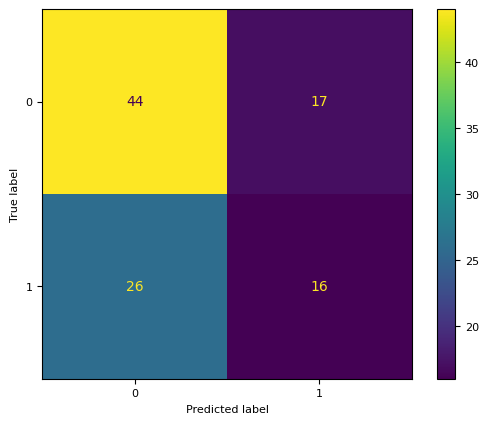

In [30]:
cm = confusion_matrix(labels.numpy(), 
                      preds.numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

In [31]:
model

WaterModel2(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## 1.3 Vanishing and exploding gradients

**Exploding gradients problems**

- Gradients get bigger and bigger
- Parameter updates are too large
- Training diverges

**Solution to unstable gradients**
1. Proper weights initialization
2. Good activations
3. Batch normalization

### Fix 1 - Proper weights initialization

In [32]:
# Build the improved model
class WaterModel3(nn.Module):
    """Improved model for binary classifier problems with a solution to
    exploding gradients problems.
    """
    def __init__(self, seed=SEED):
        super().__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
        
    def forward(self, x):
        x = x.float()
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x.double()

model = WaterModel3()
model

WaterModel3(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [33]:
# Get the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)

# Set the criterion and teh optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Train the model
losses = []
epochs = int(1e3)
model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.6741
Epoch [200], Loss: 0.6679
Epoch [300], Loss: 0.6783
Epoch [400], Loss: 0.6509
Epoch [500], Loss: 0.6451
Epoch [600], Loss: 0.6454
Epoch [700], Loss: 0.5998
Epoch [800], Loss: 0.5966
Epoch [900], Loss: 0.5555
Epoch [1000], Loss: 0.5421


In [35]:
# Evaluate the model
dataset_test = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TEST)
dataloader_test = DataLoader(dataset_test, batch_size=200, shuffle=True)
acc = Accuracy(task="binary")
model.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

accuracy = acc.compute()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.679920494556427


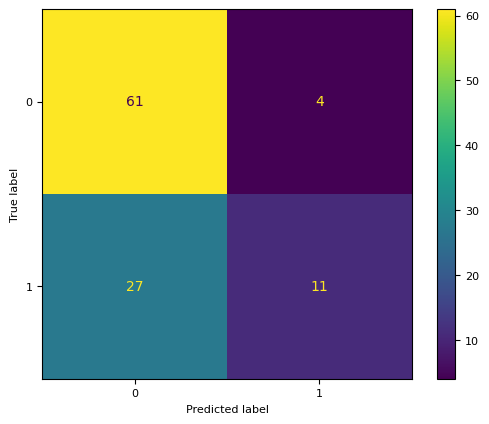

In [36]:
cm = confusion_matrix(labels.numpy(), preds.numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

### Fix 2 - Good activations

| `nn.functional.relu()` | `nn.functional.elu()` |
|----------------------|---------------------|
| Often used as the default activation | Improvement of the default activation |
| Zero for negative inputs - dying neurons | Non-zero gradients for negative values - helps against dying neurons <br>Average output around zero - helps against vanishing gradients |

In [37]:
nn.functional.elu(torch.randn(2))

tensor([-0.1162377000,  0.9525790215])

### Fix 3 - Batch normalization

After a layer:

1. Normalize the layer's outputs by:
    - Subtracting the mean
    - Dividing by the standard deviation
2. Scale and shift normalized outputs using learned parameters
    - Model learns optimal inputs distribution for each layer:
        - Faster loss decrease
        - Helps against unstable gradients

In [38]:
# Build the improved model
class WaterModel4(nn.Module):
    """Improved model for binary classifier problems with batchnormalization.
    """
    def __init__(self, seed=SEED):
        super().__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(9, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
        
    def forward(self, x):
        x = x.float()
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)
        x = nn.functional.sigmoid(self.fc3(x))
        return x.double()

model = WaterModel4()
model

WaterModel4(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [39]:
# Get the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)

# Set the criterion and teh optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Train the model
losses = []
epochs = int(1e3)
model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [100], Loss: 0.6299
Epoch [200], Loss: 0.5614
Epoch [300], Loss: 0.5787
Epoch [400], Loss: 0.5237
Epoch [500], Loss: 0.4658
Epoch [600], Loss: 0.6694
Epoch [700], Loss: 0.5122
Epoch [800], Loss: 0.5221
Epoch [900], Loss: 0.4475
Epoch [1000], Loss: 0.4968


In [41]:
# Evaluate the model
dataset_test = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TEST)
dataloader_test = DataLoader(dataset_test, batch_size=200, shuffle=True)
acc = Accuracy(task="binary")
model.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

accuracy = acc.compute()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.6600397825241089


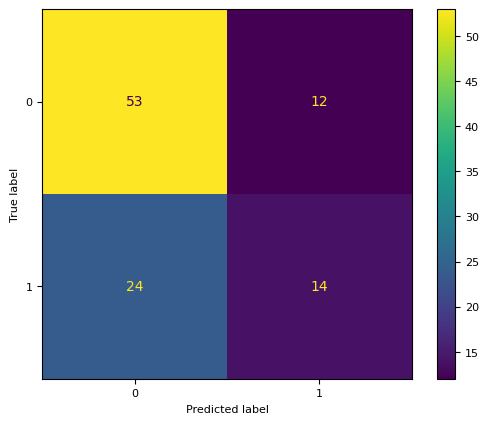

In [42]:
cm = confusion_matrix(labels.numpy(), preds.numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

### Ex.4 - Initialization and activation
The problems of unstable (vanishing or exploding) gradients are a challenge that often arises in training deep neural networks. In this and the following exercises, you will expand the model architecture that you built for the water potability classification task to make it more immune to those problems.

As a first step, you'll improve the weights initialization by using He (Kaiming) initialization strategy. To do so, you will need to call the proper initializer from the torch.nn.init module, which has been imported for you as init. Next, you will update the activations functions from the default `ReLU` to the often better `ELU`.

**Instructions**

1. Call the He (Kaiming) initializer on the weight attribute of the second layer, `fc2`, similarly to how it's done for `fc1`.
2. Call the He (Kaiming) initializer on the weight attribute of the third layer, `fc3`, accounting for the different activation function used in the final layer.
3. Update the activation functions in the `forward()` method from `relu` to `elu`.

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
        # Apply He initialization
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        # Update ReLU activation to ELU
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x
model = Net()
model

Net(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

## Ex.5 - Batch Normalization
As a final improvement to the model architecture, let's add the batch normalization layer after each of the two linear layers. The batch norm trick tends to accelerate training convergence and protects the model from vanishing and exploding gradients issues.

Both `torch.nn` and `torch.nn.init` have already been imported for you as `nn` and `init`, respectively. Once you implement the change in the model architecture, be ready to answer a short question on how batch normalization works!

**Instructions**

1. Add two `BatchNorm1d` layers assigning them to `self.bn1` and `self.bn2`.
2. In the `forward()` method, pass `x` through the second set of layers: the linear layer, the batch norm layer, and the activations, similarly to how it's done for the first set of layers.
3. Which of the following statements is true about batch normalization?
> **Possible answers**
> - [ ] Adding batch normalization doesn't impact the number of parameters the model has to learn.
> - [ ] Batch normalization normalizes a layer's inputs to a standard normal distribution and passes these normalized values further.
> - [X] Batch normalization effectively learns the optimal input distribution for each layer it precedes.

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

model = Net()
model

Net(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

-----------------------------